## Breast Cancer Diagnosis - Feature and Model Selection

Here we'll examine a set data from patients with breast tumors diagnosed as 'Malignant' and 'Benign'. We'll find the most diagnostic features and try two models for predicting diagnoses.

In [36]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

### The Data
The file contains data from 569 patients suspected of having malignant breast tumors. Variables include:

1) a Patient ID

2) A diagnosis, 'Malignant' or 'Benign'

3 - 32) 30 features consisting of various measurements from a sample of biopsied tumor cells.

Let's load the data and do some cleaning.


In [3]:
df = pd.read_csv('~/Dropbox/thinkful/Thinkful_datasets/breast_cancer_wisconsin/Breast_Cancer_Wisconsin_Malig_Benign.csv')
# drop ID column
df.drop('ID', axis=1, inplace=True)
# recode the diagnoses
df['Diagnosis'] = np.where(df['Diagnosis'] == 'B', 0, 1)
# remove missing data
df.replace('?', np.nan, inplace=True)
df.dropna(inplace = True)

Check for imbalance in the distribution of diagnoses.

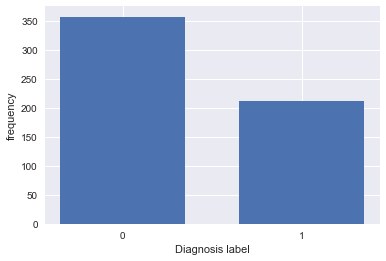

In [19]:
plt.figure()
plt.hist(df['Diagnosis'], bins=np.arange(3)-.5, align='mid', rwidth=.7)
plt.xlabel('Diagnosis label')
plt.ylabel('frequency')
plt.xticks([0, 1])
plt.show()

There are 75% more negative cases in the data set. We'll take that into account if we get biases in the model performance.

### A Random Forest Model
Prior to doing any feature selection, let's fit a Random Forest classifier using all features

In [20]:
# define a function to return classification results
def results(y_test, y_pred, display):
    # accuracy, hits, true_negatives, misses, false_positives
    acc = sum(y_test == y_pred)/len(y_test)
    tpos = sum((y_test == 1) & (y_pred==1))/sum(y_test == 1)
    tneg = sum((y_test == 0) & (y_pred==0))/sum(y_test == 0)
    fneg = sum((y_test == 1) & (y_pred==0))/sum(y_test == 1)
    fpos = sum((y_test == 0) & (y_pred==1))/sum(y_test == 0)
    if display:
        # print the results
        print('accuracy = ', acc)
        print('hits = ', tpos)
        print('misses = ', fneg)
        print('true negatives = ', tneg)
        print('false positives = ', fpos)
    # save the results
    return {'acc': acc, 'tpos': tpos, 'tneg': tneg, 'fneg': fneg, 'fpos': fpos}

In [25]:
# fit the RF model
X = df.drop('Diagnosis', axis=1)
Y = df['Diagnosis']

params = {'n_estimators': 5,   
          'criterion': 'entropy',  
          'max_depth': 8,         
          'max_features': 1,
          'random_state': 42}

features = X.keys()
# Use ~100 patients for the test set
X_train, X_test, Y_train, Y_test = train_test_split(X[features].values, Y.values, test_size = 1/6)
rfc = ensemble.RandomForestClassifier(**params)

rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
result = results(Y_test, y_pred, True)

accuracy =  0.947368421053
hits =  0.925
misses =  0.075
true negatives =  0.963636363636
false positives =  0.0363636363636


The model achieves fairly high accuracy with only a slight bias in Sensitivty ('hits') and Specificity ('true negatives'). 

Next, let's try to extract a minimum number of maximally predictive features. 

### Feature Selection
Let's do a simple correlation analysis to determine how much each feature correlates with the diagnoses.

In [26]:
# get the correlations
corrs = df.corr()
# sort 
corrs_list = list((zip(list(corrs['Diagnosis'].index), list(abs(corrs['Diagnosis'].values)))))
corrs_sort = sorted(corrs_list, key = lambda item: item[1])
corrs_sort = corrs_sort[:-1]
corrs_sort = list(zip(*corrs_sort))

Next we'll fit the Random Forest model to subsets of the features. We'll add each feature in decreasing order of its correlation with the diagnosis and look at how the accuracy changes with each additional feature. 

In [27]:
# resort the features from max to min
features_cor = np.array(corrs_sort[0])[::-1]

# do this many model fits for each feature set size
iters = 100

# get training and testing sets (larger testing set results in more stable 
# accuracy estimates across iterations of the fits)
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 1/3)

# allocate variable for the classification accuracy
accuracy_cor = np.empty((iters,  len(features_cor)))

# RF params
params = {'n_estimators': 5,   
          'criterion': 'entropy',  
          'max_depth': 15,         
          'max_features': 1}

# fit the model adding features on each iteration
for iter in range(iters):
    for count, f in enumerate(features_cor):
        features = features_cor[:count+1]
        x_train = X_train[features].values
        x_test = X_test[features].values
        clf = ensemble.RandomForestClassifier(**params)
        clf.fit(x_train, Y_train)
        y_pred = clf.predict(x_test)
        result = results(np.ravel(Y_test.values), y_pred, False)
        accuracy_cor[iter,count] = result['acc']

## Plot 1 - Most Predictive Features

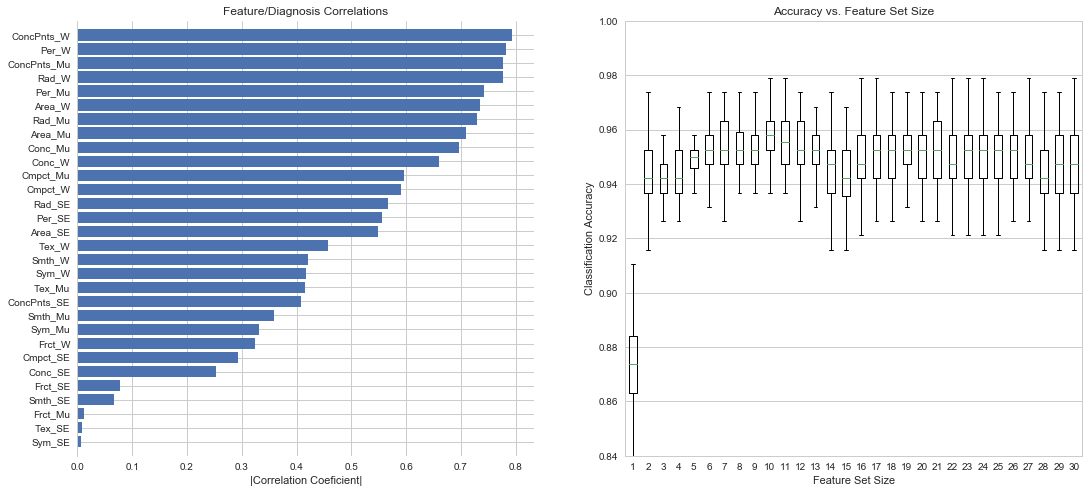

In [28]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,2,1)
plt.barh(range(len(corrs_sort[1])), corrs_sort[1])
plt.ylim([-1, len(corrs_sort[1])])
plt.yticks(range(len(corrs_sort[0])), corrs_sort[0])
plt.title('Feature/Diagnosis Correlations')
plt.xlabel('|Correlation Coeficient|')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(1,2,2)
plt.boxplot(accuracy_cor)
plt.ylim([.84, 1])
plt.ylabel('Classification Accuracy')
plt.xlabel('Feature Set Size')
plt.title('Accuracy vs. Feature Set Size')
ax.xaxis.grid(False)

plt.show()

The **Left** plot shows the correlation of each of the 30 features with the diagnoses. 

The **Right** plot shows the distribtuion of accuracy across 100 iterations of the RF model for each set size, where the features are added to the set in decreasing order of their correlation.

Accuracy increases consistently for the first 10 features. These features describe the Area, Perimeter, and Radius of the tumor in addition to its Concavity and Number of Concave Points, quantifying the 'bumpiness' of the contour of the tumor.

Next, let's try reducing the feature space further by taking an optimal combination of these 10 features.

### Dimensionality reduction using PCA

In [29]:
# function to do PCA
def doPCA(df, features, n_comps):
    # get PCs
    X = df[features]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=len(features))
    pca.fit(X)
    # project X onto the components
    for i in range(n_comps):
        P = pca.components_[:i+1]
        X_new = np.dot(P,X.T)
    result = {'X_new': X_new, 'ex_var': pca.explained_variance_ratio_}    
    return X_new

# get first 10 most highly correlated features
best_features = corrs_sort[0][::-1]
best_features = np.array(best_features[:10])

# do PCA and project data onto 1 to 10 components
n_comps = len(best_features)
pca_dict = {}
for comps in range(n_comps):
    x_new = doPCA(df, best_features, comps+1)
    pca_dict[comps+1] = x_new
 
# now fit the RF model to optimally combined features 
scores = np.array([])
# RF params
params = {'n_estimators': 5,   
          'criterion': 'entropy',  
          'max_depth': 15,         
          'max_features': 1,
          'random_state': 42}
for key, feature_vecs in pca_dict.items():
    X = feature_vecs.T
    clf = ensemble.RandomForestClassifier(**params)
    cv_score = cross_val_score(clf, X, Y, cv=10)
    if scores.size == 0:
       scores = cv_score
    else:
        scores = np.vstack((scores, cv_score))   
        
# add 2d data to the dataframe
df['F1'] = pd.Series(pca_dict[1][0])
df['F2'] = pd.Series(pca_dict[2][0])        

In [30]:
# functions to plot decisions boundaries and diagnosis distributions
def decision_bounds(scale_x, scale_y, df, features, target, model, ax): 
    # extract features and targets
    X = df[features].values
    Y = df[target].values
    
    # get model predictions for all values
    xx, yy = np.meshgrid(scale_x, scale_y)
    XX = np.c_[xx.ravel(), yy.ravel()]
    pred = model.predict(XX)
    pred = pred.reshape(xx.shape)
    
    # plot decision bounds
    plt.set_cmap(plt.cm.Paired)
    plt.pcolormesh(xx, yy, pred)

    # plot the data
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors=[0, 0, 0])
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Decision Bounds')
    
    # clean up
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def kde_plot(scale_x, scale_y, df, features, target, ax):   
    # color maps
    cmap_navy_pal=sns.light_palette('navy', as_cmap=True)
    cmap_green_pal=sns.light_palette('green', as_cmap=True)
    cmap_navy=sns.light_palette('navy', as_cmap=False)
    cmap_green=sns.light_palette('green', as_cmap=False)

    # plot KDE of diagnosis distributions
    sns.kdeplot(df.loc[df[target]==1, features[0]], 
                df.loc[df[target]==1, features[1]], cmap=cmap_navy_pal)
    sns.kdeplot(df.loc[df[target]==0, features[0]], 
                df.loc[df[target]==0, features[1]], cmap=cmap_green_pal)
    ax.text(6, 9, "malignant", size=16, color=cmap_navy[-2])
    ax.text(-2, -4, "benign", size=16, color=cmap_green[-2])
    plt.title('Diagnosis distributions')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    
    # clean up
    xx, yy = np.meshgrid(scale_x, scale_y)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Plot 2 - Visualizing the data in a low-dimensional feature space

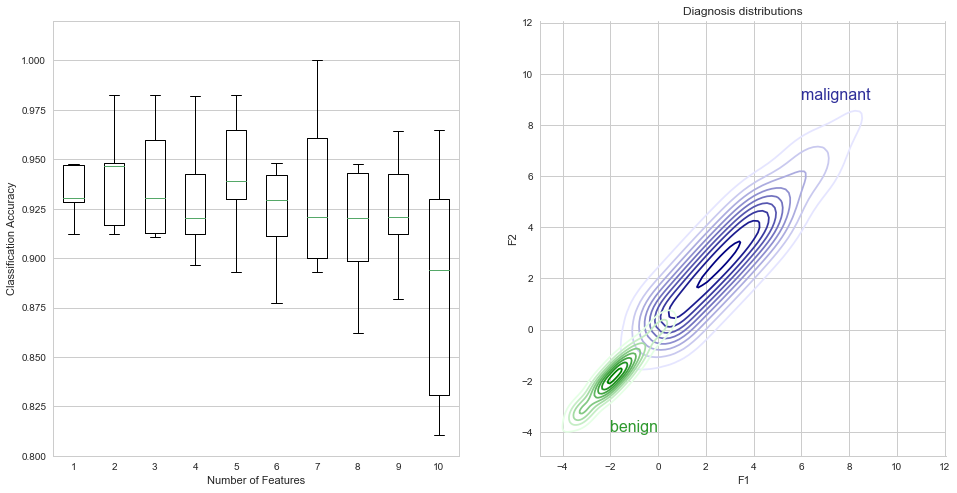

In [31]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1)
plt.boxplot(scores.T)
plt.ylim([.8, 1.02])
plt.ylabel('Classification Accuracy')
plt.xlabel('Number of Features')
plt.gca().xaxis.grid(False)

scale_x = np.arange(min(min(df['F2']), min(df['F1'])), max(max(df['F2']), max(df['F1'])))
scale_y = scale_x
features = ['F1', 'F2']
target = 'Diagnosis'
ax = fig.add_subplot(1,2,2)
kde_plot(scale_x, scale_y, df, features, target, ax)

plt.show()

The **Left** plot shows the distribution of classification accuracy (using 10-fold cross validation) as a function of number of features used in the model. Each set of $N$ features was derived by projecting the 10 best features (determined above using correlation) onto $N$ principle components. Median accuracy is highest using 2 features.

The **Right** plot shows kernel density estimates of the distributions of benign and malignant tumors in the 2D feature space.  

It appears that a simple linear decision boundary in this 2D feature space will be appropriate. Below, we'll try a Random Forest model and compare it to a simple linear regression.

### Model Selection - Random Forest

In [32]:
# define a function to do leave-one-out CV
def cv_loo(X, Y, model):
    y_pred = []
    p_pred = np.empty((0,2))
    for i in range(X.shape[0]):      
        ind = list(range(X.shape[0]))
        ind_tr = [j for j in ind if j != i]
        ind_te = i
        if X.shape[1] > 1:
            X_train = X[ind_tr, :]
            X_test = X[i, :]
        else:    
            X_train = X[ind_tr]
            X_test = X[i]
        Y_train = Y[ind_tr]
        Y_test = Y[i]
        model.fit(X_train, Y_train)
        y_pred.append(model.predict([X_test]))
        p_pred = np.vstack([p_pred,model.predict_proba([X_test])])
    result = {'y_pred': np.array(y_pred), 'y_true': Y, 'p_pred': p_pred}
    return result

accuracy =  0.945518453427
hits =  0.915094339623
misses =  0.0849056603774
true negatives =  0.963585434174
false positives =  0.0364145658263


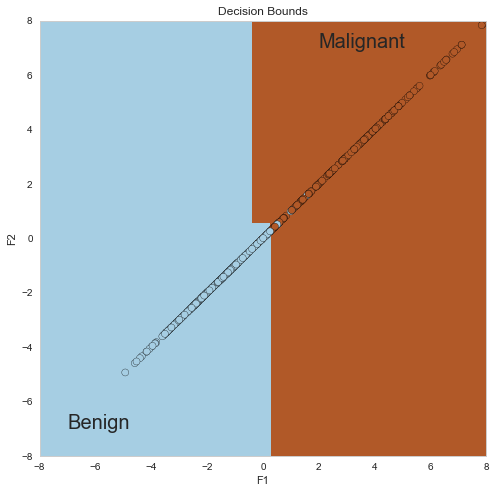

In [34]:
# fit a RF model
features = ['F1', 'F2']
X = df[features].values
Y = df['Diagnosis'].values
params = {'n_estimators': 8,   
          'criterion': 'entropy',  
          'max_depth': 1,         
          'max_features': 1,
          'random_state': 42}
rf_model = ensemble.RandomForestClassifier(**params)
fit = rf_model.fit(X, Y)
cv_result = cv_loo(X, Y, rf_model)
result = results(cv_result['y_true'], np.ravel(cv_result['y_pred']), True)

# plot data and decision bounds
scale_x = np.arange(-8, 8, .01)
scale_y = np.arange(-8, 8, .01)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
decision_bounds(scale_x, scale_y, df, features, 'Diagnosis', rf_model, ax)
ax.text(-7, -7, 'Benign', size=20)
ax.text(2, 7, 'Malignant', size=20)
plt.show()

The plot shows the decision boundary derived from the Random Forest model fit to the 2 optimized features resulting from the PCA. Circles show individual data points for Benign (Blue) and Malignant (Brown) cases. 

The Random Forest model results in 95% leave-one-out crossvalidated accuracy with a slight bias between Sensitivity and Specificity. Let's compare this performance to a Logistic Regression model. 

### Model Selection - Logistic Regression

accuracy =  0.940246045694
hits =  0.915094339623
misses =  0.0849056603774
true negatives =  0.955182072829
false positives =  0.0448179271709


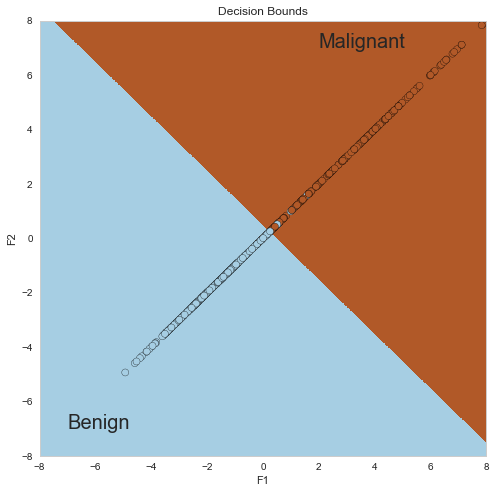

In [35]:
# fit a Logistic Regression model
features = ['F1', 'F2']
X = df[features].values
Y = df['Diagnosis'].values
lr_model = LogisticRegression()
fit = lr_model.fit(X, Y)
cv_result = cv_loo(X, Y, lr_model)
result = results(cv_result['y_true'], np.ravel(cv_result['y_pred']), True)

# plot data and decision bounds
scale_x = np.arange(-8, 8, .01)
scale_y = np.arange(-8, 8, .01)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
decision_bounds(scale_x, scale_y, df, features, 'Diagnosis', lr_model, ax)
ax.text(-7, -7, 'Benign', size=20)
ax.text(2, 7, 'Malignant', size=20)
plt.show()

The Logistic Regression model achieves 94%.

The Random Forest model has slightly higher Specificity.

## Conclusion
In our Feature Selection analysis, we identified 10 out of 30 features that are daignostic of breast cancer malignancies. These features describe the size, shape, and 'bumpiness' of the contour of the tumor. 

Further Feature Engineering reduced the dimensionality of the feature space to 2. 

A Random Forest model achieves 95% accuracy using these two features and has slightly higher Specificity than a Logistic Regression model that uses the same features.